In [49]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns


#==================================
# 1. Carga del Dataset
#==================================


#Debido a que el csv tenia "";" , "","" y otros simbolos que causaban que no se pudiese analizar, se filtra
data = pd.read_csv(
    "fra_cleaned.csv",
    sep=";",
    encoding="latin1",
    quotechar='"',
    engine="python",
)
data.head()
print(data.shape)

(24063, 18)


In [50]:
#Eliminamos de antemano columnas que no seran utiles para el estudio
data= data.drop(columns=["url", "Country", "Year", "Perfumer1", "Perfumer2"])
data.head()

,Perfume,Brand,Gender,Rating Value,Rating Count,Top,Middle,Base,mainaccord1,mainaccord2,mainaccord3,mainaccord4,mainaccord5
0,accento-overdose-pride-edition,xerjoff,unisex,"1,42",201,"fruity notes, aldehydes, green notes","bulgarian rose, egyptian jasmine, lily-of-the-...","eucalyptus, pine",rose,woody,fruity,aromatic,floral
1,classique-pride-2024,jean-paul-gaultier,women,"1,86",70,"yuzu, citruses","orange blossom, neroli","musk, blonde woods",citrus,white floral,sweet,fresh,musky
2,classique-pride-2023,jean-paul-gaultier,unisex,"1,91",285,"blood orange, yuzu","neroli, orange blossom","musk, white woods",citrus,white floral,sweet,fresh spicy,musky
3,pride-edition-man,bruno-banani,men,"1,92",59,"guarana, grapefruit, red apple","walnut, lavender, guava","vetiver, benzoin, amber",fruity,nutty,woody,tropical,NaN
4,le-male-pride-collector,jean-paul-gaultier,men,"1,93",632,"mint, lavender, cardamom, artemisia, bergamot","caraway, cinnamon, orange blossom","vanilla, sandalwood, amber, cedar, tonka bean",aromatic,warm spicy,fresh spicy,cinnamon,vanilla


In [51]:
#==================================
# 2. Analisis explorativo
#================================

print("Número de perfumes:", data.shape[0])
print("Columnas:", data.columns.tolist())

Número de perfumes: 24063
Columnas: ['Perfume', 'Brand', 'Gender', 'Rating Value', 'Rating Count', 'Top', 'Middle', 'Base', 'mainaccord1', 'mainaccord2', 'mainaccord3', 'mainaccord4', 'mainaccord5']


In [52]:
print(data.isnull().sum())


Perfume           0
Brand             0
Gender            0
Rating Value      0
Rating Count      0
Top               0
Middle            0
Base              0
mainaccord1       0
mainaccord2      13
mainaccord3     114
mainaccord4     388
mainaccord5     981
dtype: int64


In [53]:
data = data.dropna()

In [54]:
#Analizamos el tipo de datos de cada columna
print(data.dtypes)

Perfume         object
Brand           object
Gender          object
Rating Value    object
Rating Count     int64
Top             object
Middle          object
Base            object
mainaccord1     object
mainaccord2     object
mainaccord3     object
mainaccord4     object
mainaccord5     object
dtype: object


La columna de estudio, es decir Rating Value, es de tipo "object", por lo que debe de transformarse a numerica 

In [55]:
data["Rating Value"] = data["Rating Value"].str.replace(",",".", regex=False)
data["Rating Value"] = pd.to_numeric(data["Rating Value"], errors= "coerce")

In [56]:
#Analizamos el tipo de datos de cada columna
print(data.dtypes)

Perfume          object
Brand            object
Gender           object
Rating Value    float64
Rating Count      int64
Top              object
Middle           object
Base             object
mainaccord1      object
mainaccord2      object
mainaccord3      object
mainaccord4      object
mainaccord5      object
dtype: object


count    23082.000000
mean         3.962008
std          0.276461
min          1.420000
25%          3.790000
50%          3.970000
75%          4.150000
max          4.930000
Name: Rating Value, dtype: float64


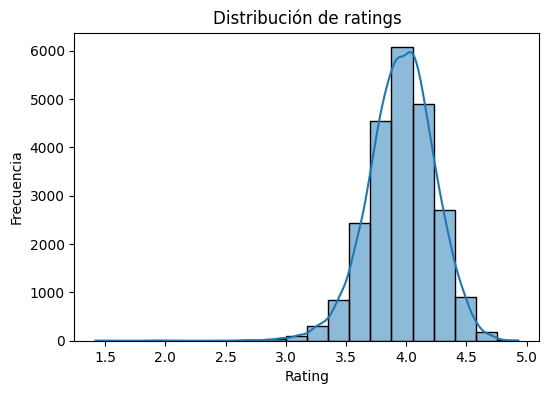

In [57]:
print(data['Rating Value'].describe())

# Distribución del rating
plt.figure(figsize=(6, 4))
sns.histplot(data['Rating Value'], bins=20, kde=True)
plt.title("Distribución de ratings")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.show()

count    23082.000000
mean       504.780522
std       1426.221716
min         26.000000
25%         56.000000
50%        128.000000
75%        364.000000
max      29722.000000
Name: Rating Count, dtype: float64


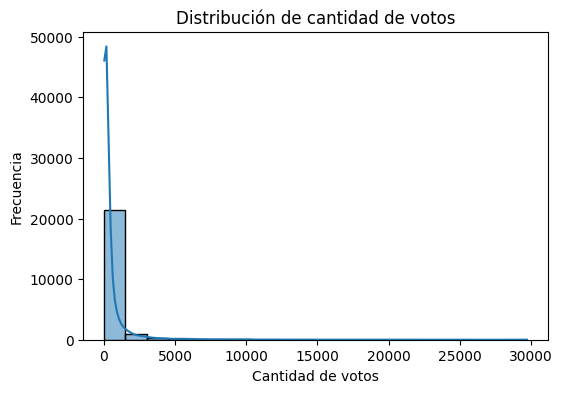

In [58]:
print(data['Rating Count'].describe())

# Distribución del rating
plt.figure(figsize=(6, 4))
sns.histplot(data['Rating Count'], bins=20, kde=True)
plt.title("Distribución de cantidad de votos")
plt.xlabel("Cantidad de votos")
plt.ylabel("Frecuencia")
plt.show()

La cantidad de votantes promedio, varia considerablemente, por lo que se decidira por eliminar aquellos perfumes en los cuales la cantidad de votos sea inferior al primer cuartil

In [59]:
min_votos = data['Rating Count'].quantile(0.25)
data = data[data['Rating Count'] >= min_votos]

In [60]:
#===========================
#3.Featuring engineering
#==========================

#Debido a que buscarmos relacionar las notas con las familias olfativas
#Convertiremos los grupos de notas en listas y posteriormente asignaremos estas a cada familia olfativa

from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
#Procesar notas: convertir de string a lista
def parse_notes(note_str):
    return [note.strip() for note in note_str.strip("[]").replace("'", "").split(",")]

data['All Notes'] = data['Top'].apply(parse_notes) + data['Middle'].apply(parse_notes) + data['Base'].apply(parse_notes)

#Codificar notas (presencia/ausencia de cada nota)
mlb = MultiLabelBinarizer()
X_notes = pd.DataFrame(
    mlb.fit_transform(data['All Notes']),
    columns=mlb.classes_,
    index=data.index
)

#Procesar familia olfativa: combinar las 5 columnas en una lista por fila
def combine_families(row):
    return [fam for fam in row if pd.notna(fam) and fam != '']

familias = data[['mainaccord1', 'mainaccord2', 'mainaccord3', 'mainaccord4', 'mainaccord5']].apply(combine_families, axis=1)

#Codificar familias olfativas (presencia/ausencia)
mlb_familias = MultiLabelBinarizer()
X_familias = pd.DataFrame(
    mlb_familias.fit_transform(familias),
    columns=mlb_familias.classes_,
    index=data.index
)


In [61]:
# ================================================
# 4. Division de datos en Entrenamiento y Prueba
# ================================================

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

X = pd.concat([X_notes, X_familias], axis=1)
y = pd.to_numeric(data['Rating Value'], errors='coerce')

#Creacion conjunto de entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [62]:
# Entrenar modelo
model = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [63]:
#=========================
#5.Evaluacion y metricas
#=========================

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

MAE: 0.190
RMSE: 0.248
R²: 0.096


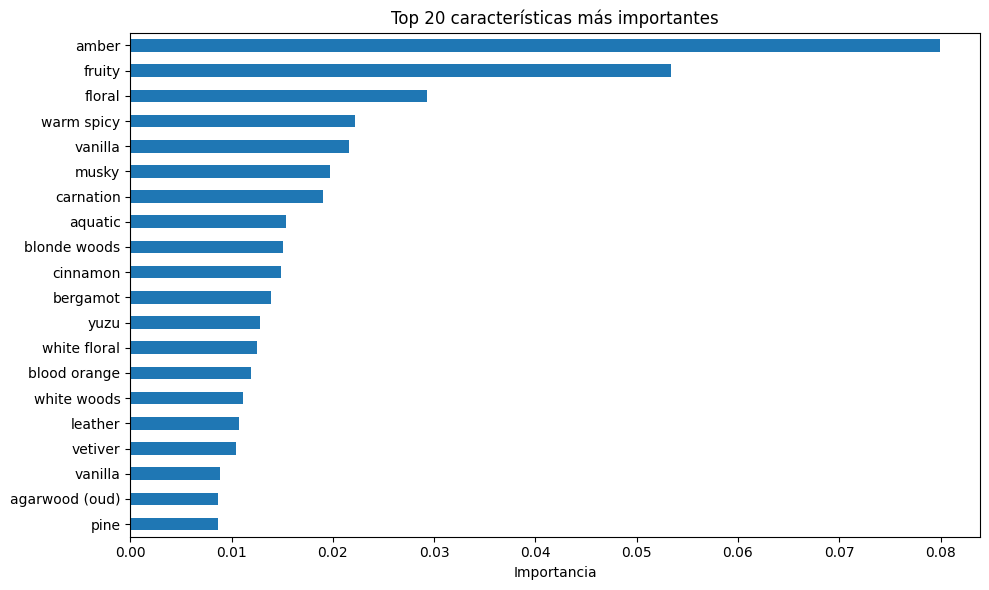

In [66]:
#==================================
#6. Analisis y visualizacion de notas
#==================================

importances = pd.Series(model.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.title("Top 20 características más importantes")
plt.xlabel("Importancia")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()